<a href="https://colab.research.google.com/github/choikanghoon/Aiffel_study/blob/master/Exploration/Ex01/flowers(%EA%BD%83)_%EB%B6%84%EB%A5%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


In [3]:
import tensorflow_datasets as tfds

tfds.__version__

'4.9.4'

## 구글 드라이브 연동하기

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터셋 불러오기

In [5]:
from google.colab import drive
import tensorflow_datasets as tfds

# Google Drive 마운트
drive.mount('/content/drive', force_remount=True)

# 'tf_flowers'는 데이터셋의 이름입니다.
dataset_name = 'tf_flowers'

# 데이터셋 빌더를 가져옵니다.
builder = tfds.builder(dataset_name)
builder.download_and_prepare()

# 데이터셋을 불러옵니다. 'with_info=True'는 데이터셋의 정보도 함께 로드하라는 의미입니다.
(dataset, metadata) = tfds.load(
    name=dataset_name,
    split='train',
    data_dir='/content/drive/MyDrive/아이펠과정/flowers',  # 데이터셋이 저장될 로컬 폴더 경로를 지정합니다.
    download= False,  # 이미 다운로드된 데이터를 사용하려면 False로 설정합니다.
    with_info=True,
    as_supervised=True
)

# 데이터를 나눕니다.
train_size = metadata.splits['train'].num_examples
train_split = int(0.8 * train_size)
val_split = int(0.9 * train_size)

raw_train, raw_validation, raw_test = (
    dataset.take(train_split),
    dataset.skip(train_split).take(val_split - train_split),
    dataset.skip(val_split)
)

# 이후에 데이터를 사용하는 코드를 추가합니다.
# 예를 들어, 데이터 확인을 위한 코드 등을 작성할 수 있습니다.


Mounted at /content/drive


In [6]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## 데이터 이미지 시각화

%matplotlib inline # 주피터 노트북 내에서 Matplotlib의 그래프를 인라인(노트북 안에)으로 표시하도록 설정

%config InlineBackend.figure_format = 'retina' # 주피터 노트북에서 그래프의 화질을 높이기 위해 사용

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

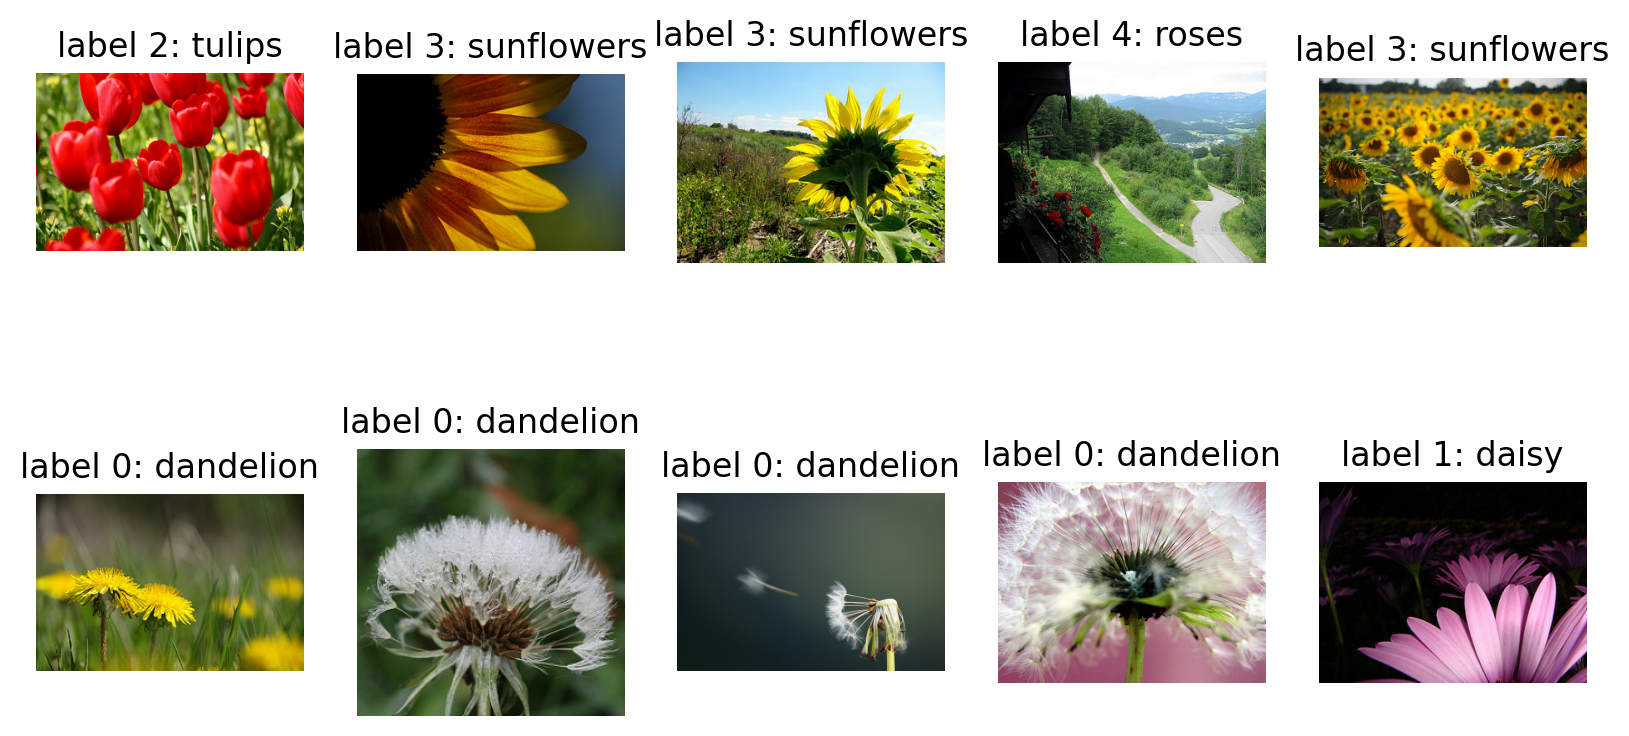

In [8]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 이미지 float32 형태 변경 및 리사이징 하기

In [9]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32) # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label


## 데이터 증강하기

In [10]:
def augment(image, label):
    image = tf.cast(image, tf.float32) # 이미지를 float32 타입으로 캐스팅
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image ,0.2)

    return image, label

# 훈련 데이터셋에 데이터 증강 적용
augmented_train = raw_train.map(augment)

In [11]:
# IMG_SIZE를 160으로 지정해 줌으로써, 모든 이미지의 크기를 (160, 160, 3)으로 통일
train = augmented_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## 데이터 증강 후 이미지 시각화
- 데이터 증강 이후 (image / 127.5 ) - 1 나 image / 255.0 을 했을 때 accuracy가 20%를 넘지 못하는 현상이 발견 되어 정규화를 포기하였다.
- 시각화 이미지가 경고와 함께 이상하게 나왔으나, 2시간 넘게 붙잡아도 해결되지 않아 넘김..

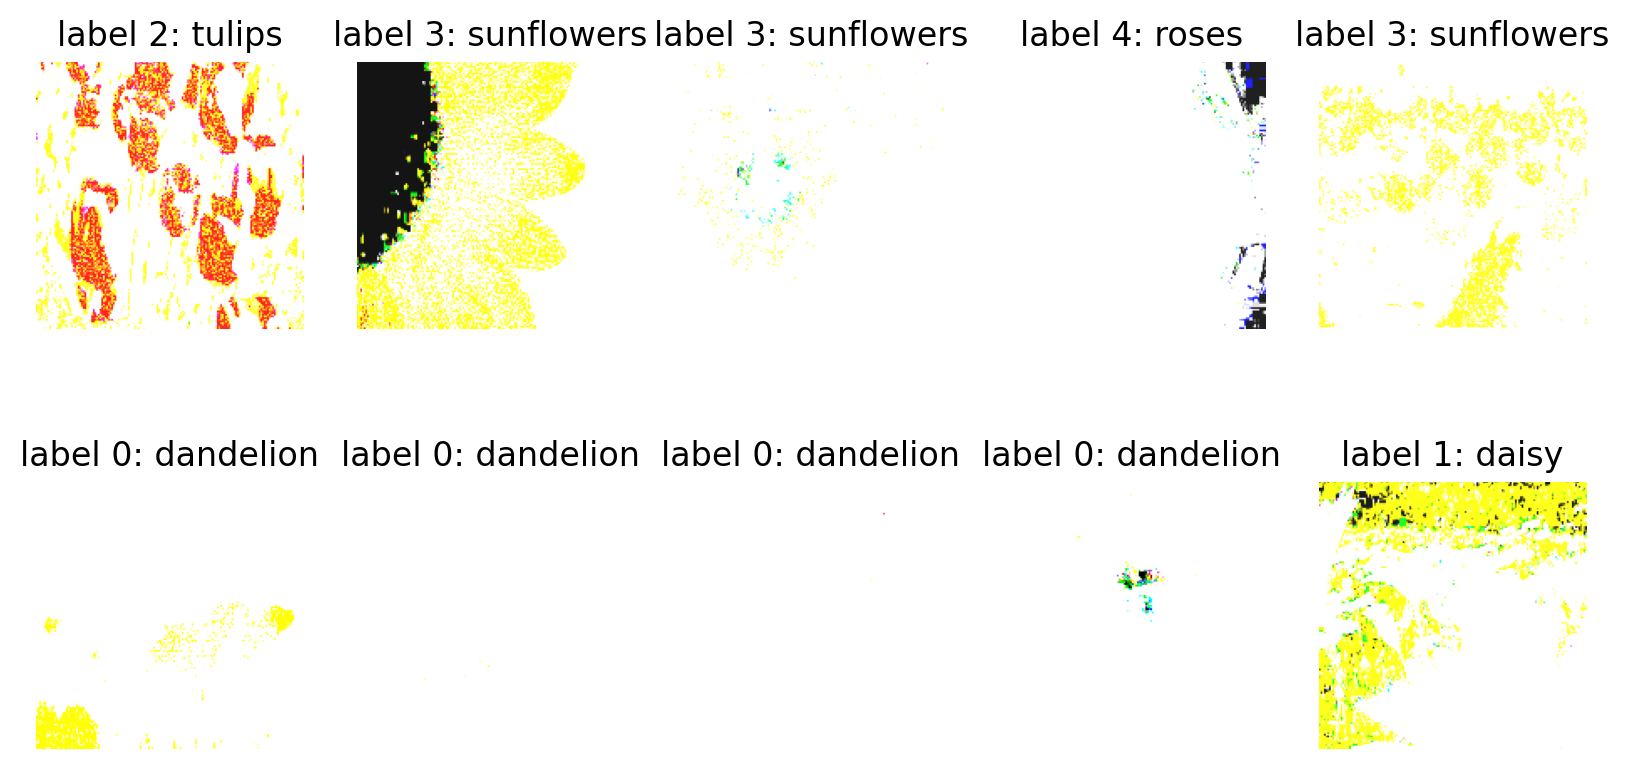

In [12]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

## VGG19 모델 불러오기

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG19
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [17]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [18]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [19]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [20]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [22]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


## VGG19 모델에 새로운 레이어 추가하기

In [23]:
# dense_layer에는 unit과 activation 2개의 매개변수만 사용
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각
# 활성화 함수는 ReLU를 사용
dense_layer1 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))

# dropout_layer 추가
dropout_layer1 = tf.keras.layers.Dropout(rate=0.2)

# 추가된 dropout_layer 적용
dense_layer2 = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))

# dropout_layer 추가
dropout_layer2 = tf.keras.layers.Dropout(rate=0.2)

# unit은 우리가 분류하고 싶은 class를 생각
# 활성화 함수는 Softmax를 사용
prediction_layer = Dense(5, activation='softmax')

# feature_batch_average가 dense_layer1을 거친 결과에 dropout_layer1를 적용
dense1_dropout1 = dropout_layer1(dense_layer1(feature_batch_average))

# dense_layer2를 거친 결과에 dropout_layer2를 적용
dense2_dropout2 = dropout_layer2(dense_layer2(dense1_dropout1))

# prediction_layer를 거친 결과
prediction_batch = prediction_layer(dense2_dropout2)
print(prediction_batch.shape)


(32, 5)


## VGG19의 가중치를 동결 후 모델 생성

In [24]:
base_model.trainable = False

In [25]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer1,
    dropout_layer1,
    dense_layer2,
    dropout_layer2,
    prediction_layer
])
print("슝~")


슝~


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [28]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 2s - loss: 12.9032 - accuracy: 0.2098

20/20 [==============================] - 12s 177ms/step - loss: 12.9032 - accuracy: 0.2098
initial loss: 12.90
initial accuracy: 0.21


## 모델 학습

In [29]:
EPOCHS = 20   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.
from keras.callbacks import ModelCheckpoint, EarlyStopping
filename = 'vgg19_model.h5'.format(EPOCHS, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss)
                              patience=10,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: 11.1101 - accuracy: 0.4489
Epoch 1: val_loss improved from inf to 9.40483, saving model to vgg19_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 22s 181ms/step - loss: 11.1101 - accuracy: 0.4489 - val_loss: 9.4048 - val_accuracy: 0.6567
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: 9.6301 - accuracy: 0.6168
Epoch 2: val_loss improved from 9.40483 to 8.92643, saving model to vgg19_model.h5
92/92 [==============================] - 15s 142ms/step - loss: 9.6301 - accuracy: 0.6168 - val_loss: 8.9264 - val_accuracy: 0.6921
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: 9.0702 - accuracy: 0.6744
Epoch 3: val_loss improved from 8.92643 to 8.59678, saving model to vgg19_model.h5
92/92 [==============================] - 16s 152ms/step - loss: 9.0702 - accuracy: 0.6744 - val_loss: 8.5968 - val_accuracy: 0.7275
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss: 8.7184 - accuracy: 0.7016
Epoch 4: val_loss improved from 8.59678 to 8.37212, saving model to vgg19_model.h5
92/92 [==============================] - 16s 137ms/step - loss: 8.7184 -

## 모델 시각화

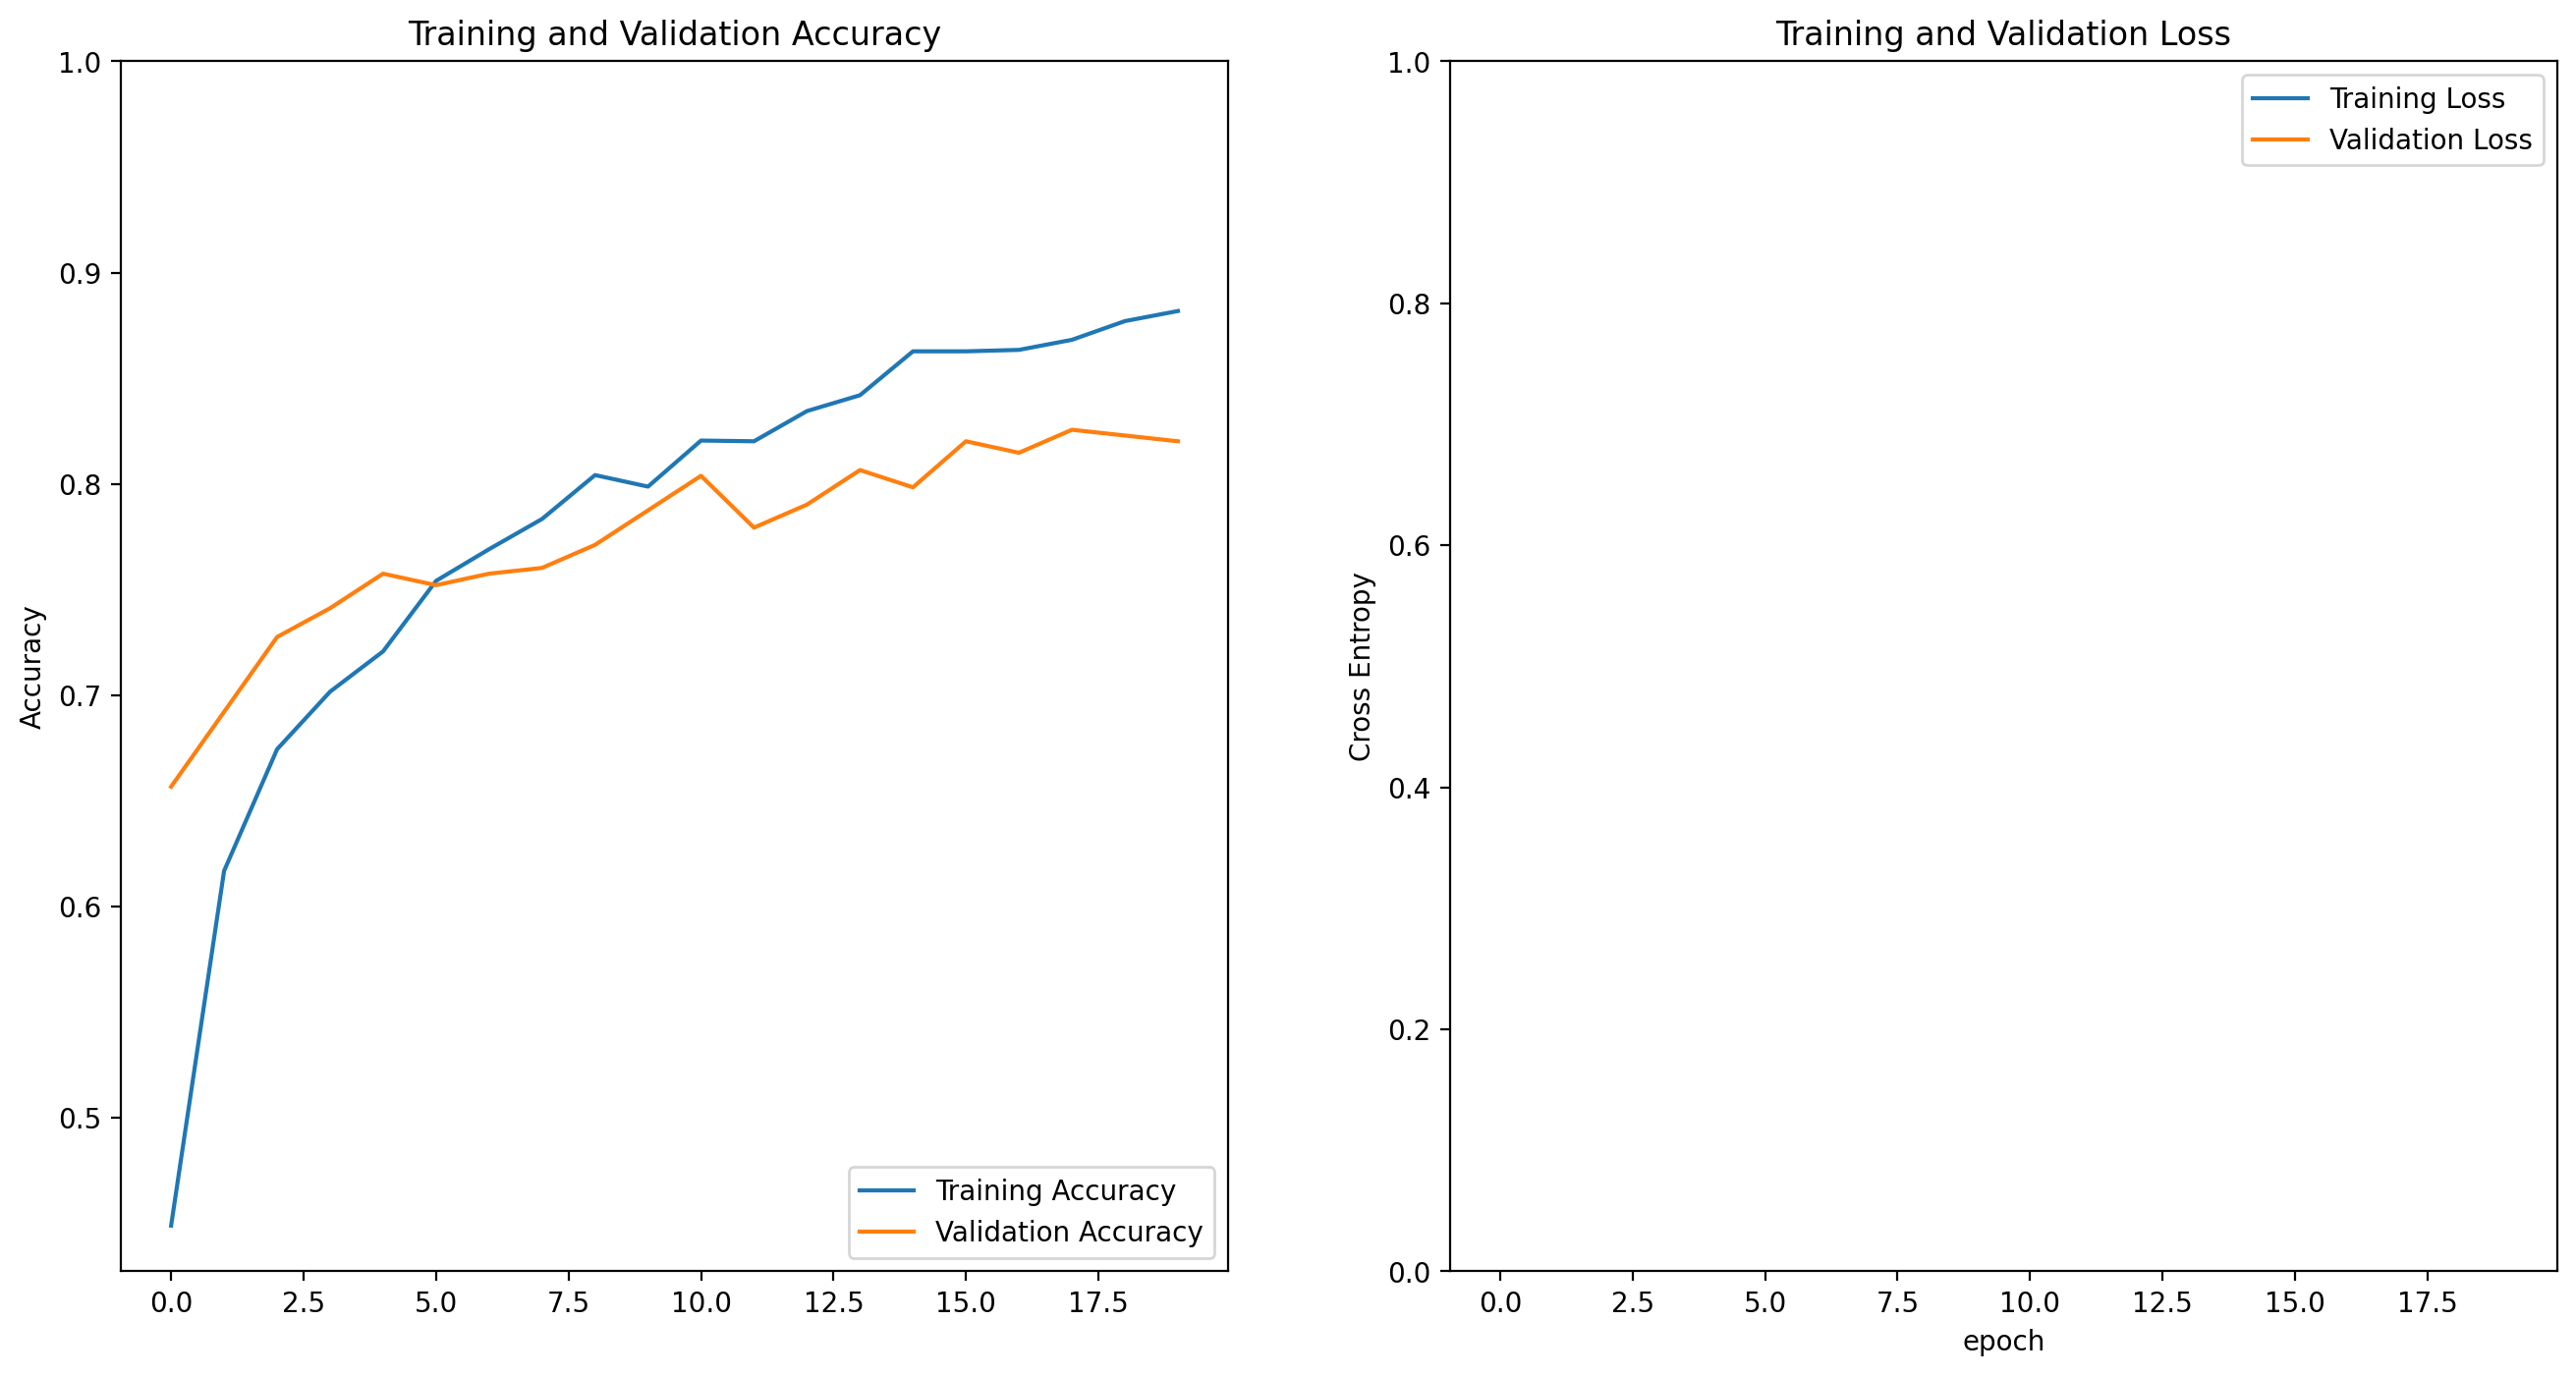

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

1/1 [==============================] - 0s 217ms/step


array([[2.38777957e-08, 9.99998927e-01, 1.57706348e-09, 1.04152139e-06,
        1.20908650e-09],
       [3.43858963e-03, 7.63009652e-04, 9.92391527e-01, 2.43412811e-04,
        3.16335168e-03],
       [6.27662189e-08, 2.97418353e-03, 2.27268059e-02, 4.16249648e-04,
        9.73882735e-01],
       [6.40204780e-06, 2.19484582e-06, 9.96539593e-01, 4.83390701e-04,
        2.96851504e-03],
       [1.70964971e-02, 6.64193183e-02, 6.56398952e-01, 2.52647027e-02,
        2.34820589e-01],
       [9.99192536e-01, 1.99130678e-04, 1.62502474e-04, 1.75883033e-05,
        4.28253581e-04],
       [9.99154925e-01, 4.51433472e-04, 5.52859710e-05, 2.34088046e-04,
        1.04348059e-04],
       [5.64966261e-01, 2.10657448e-01, 1.44998217e-02, 1.88100949e-01,
        2.17755213e-02],
       [9.40156639e-01, 7.32507929e-03, 4.75484971e-03, 4.54044901e-02,
        2.35891342e-03],
       [2.48577874e-02, 5.93086518e-03, 6.32957518e-01, 1.45565644e-01,
        1.90688267e-01],
       [4.31495048e-02, 7.7673

In [32]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([1, 2, 4, 2, 2, 0, 0, 0, 0, 2, 4, 2, 2, 4, 4, 1, 3, 3, 2, 1, 0, 0,
       2, 4, 2, 2, 1, 3, 0, 1, 1, 2])

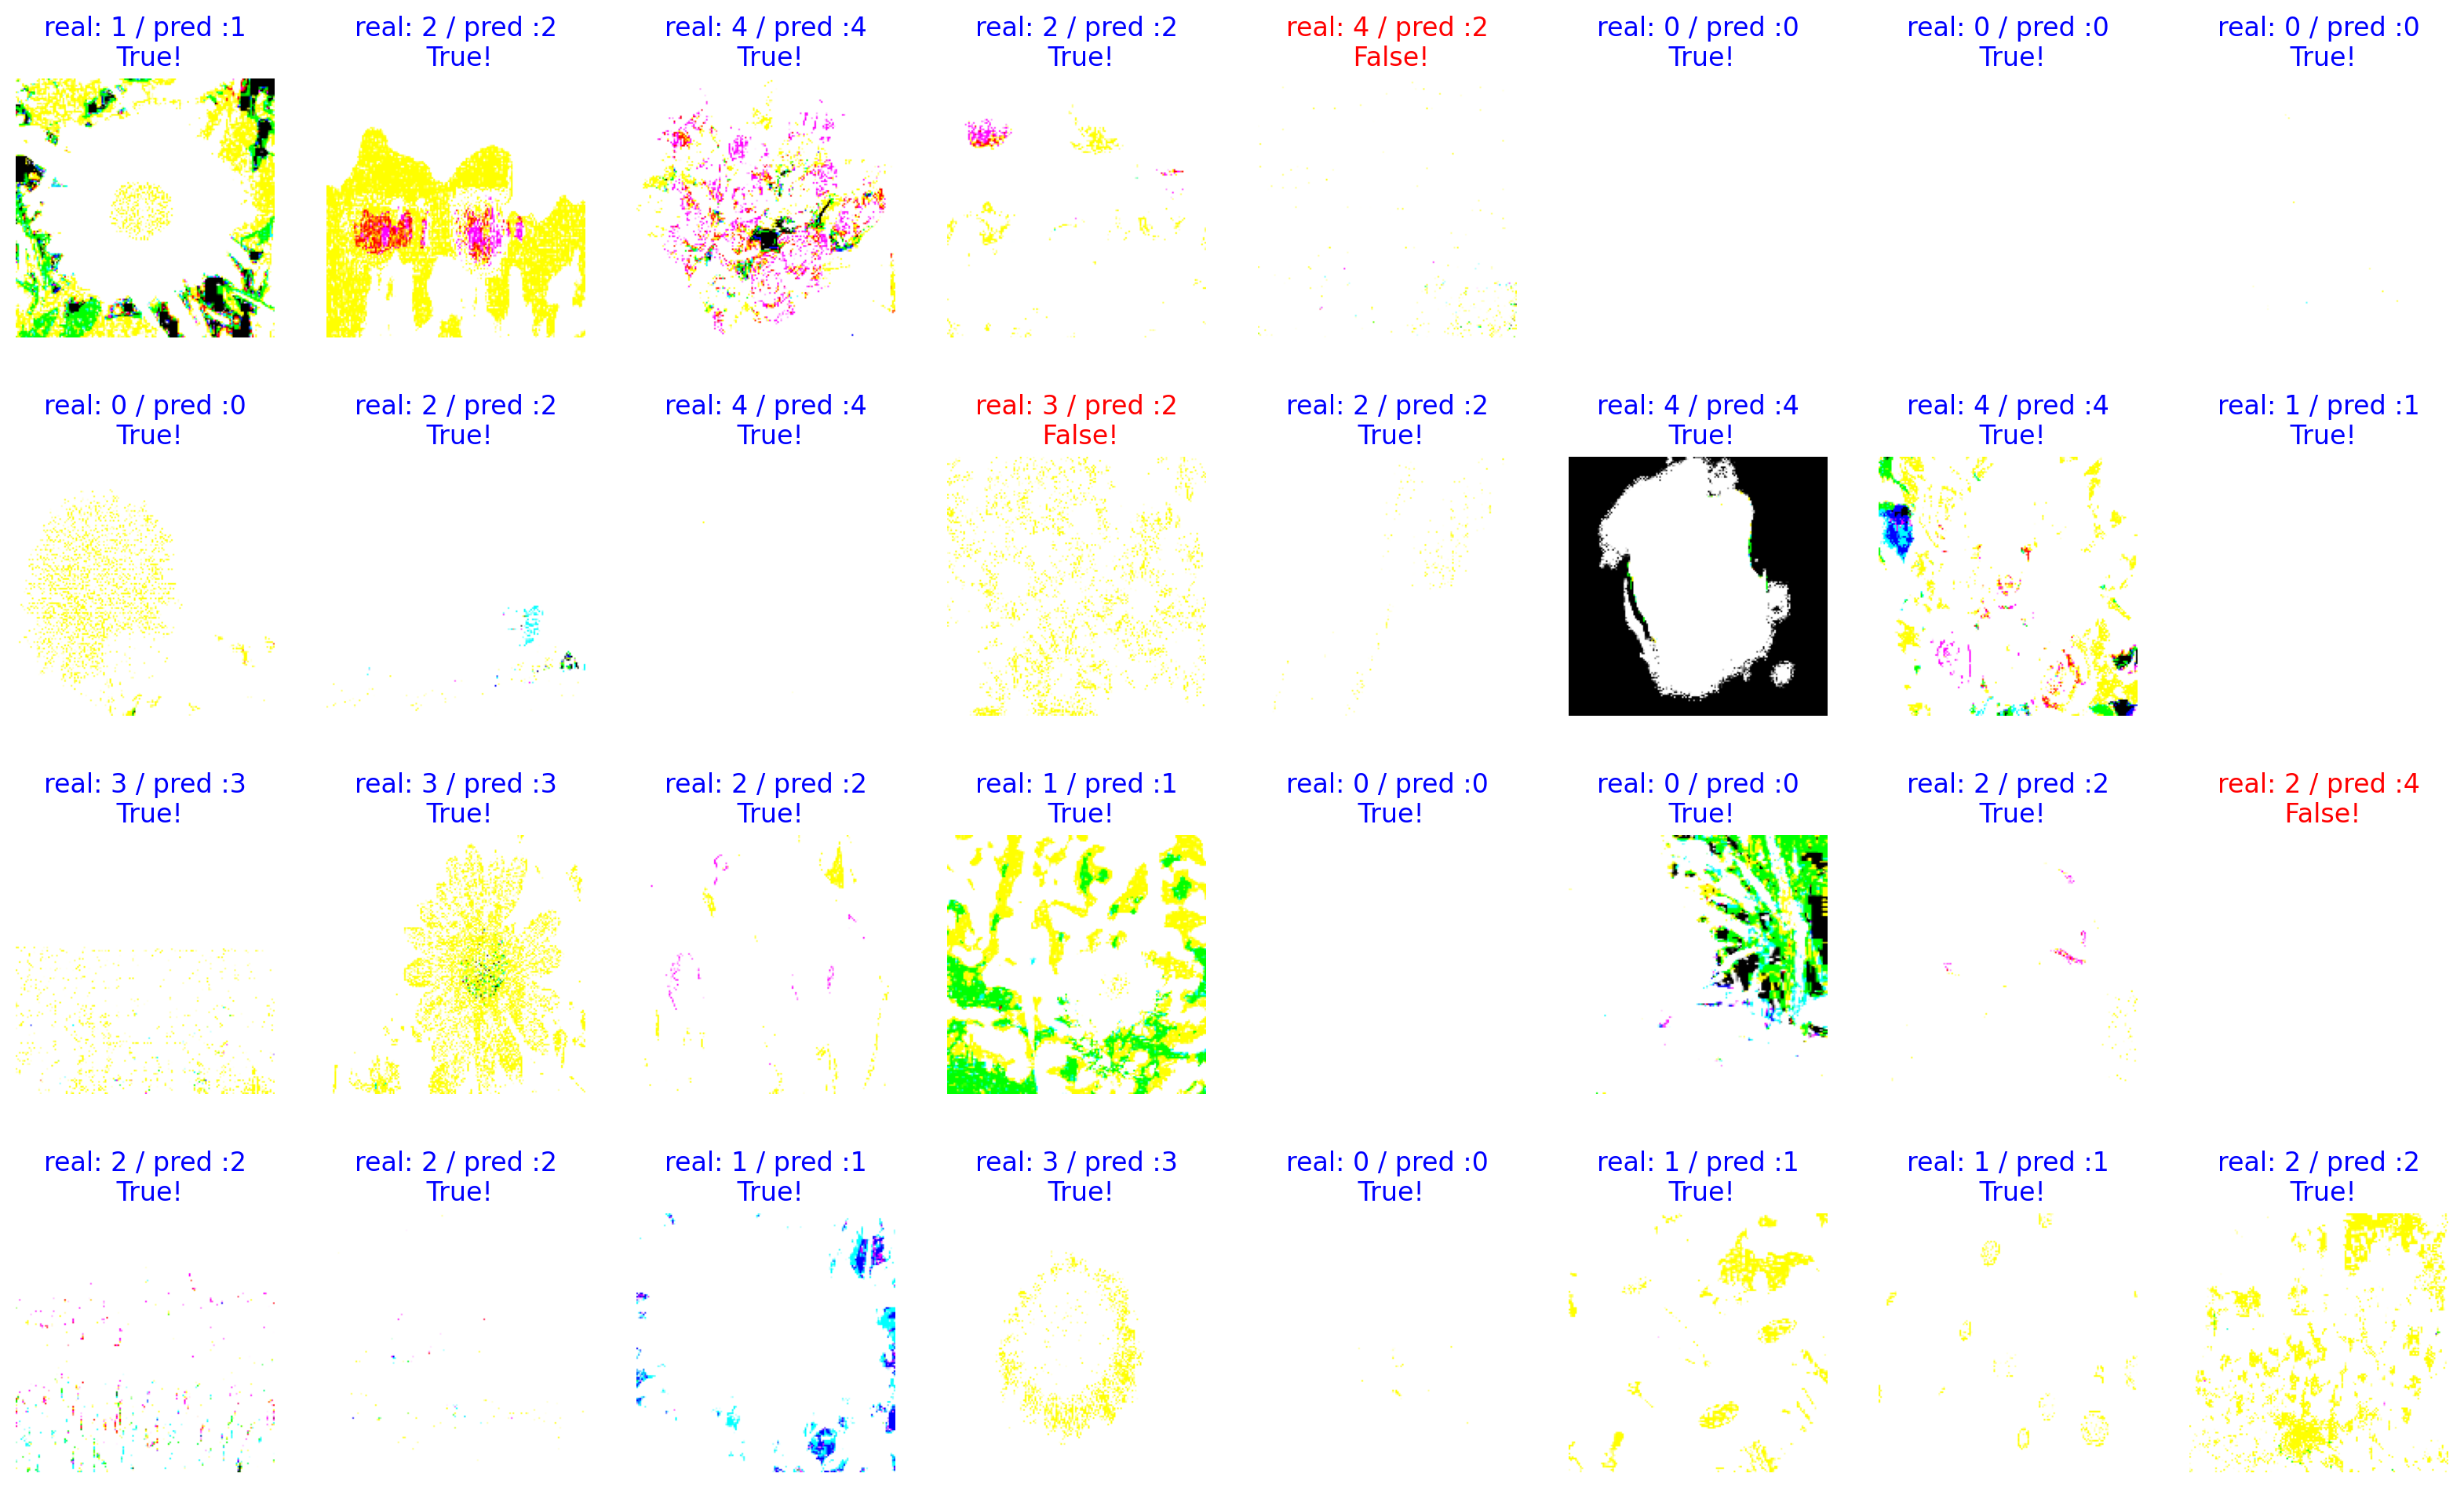

In [33]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [34]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

90.625


## 테스트 결과 도출

In [35]:
test_loss, test_accuracy = model.evaluate(test_batches)

print(f"Test Loss : {test_loss}")
print(f"Test Accuracy : {test_accuracy}")

12/12 [==============================] - 6s 79ms/step - loss: 4.9137 - accuracy: 0.8447
Test Loss : 4.91367244720459
Test Accuracy : 0.8446866273880005


### 첫번째 결과
- 데이터 증강 좌우 반전만 주었을 때

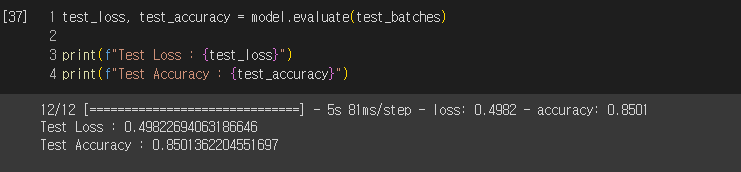

### 두번째 결과
- 데이터 증강 좌우 반전 + 상하 반전 주었을 때

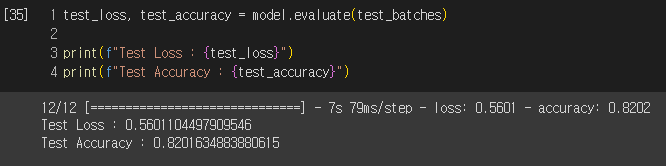

### 세번째 결과
- 데이터 증강 좌우 반전 + 상하 반전 + 밝기 0.2 주었을 때

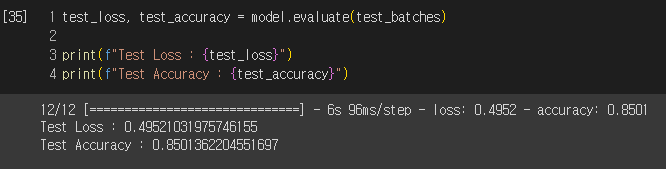

### 네번째 결과
- 데이터 증강 좌우 반전 + 상하 반전 + 밝기 0.2 + L2규제(0.001)

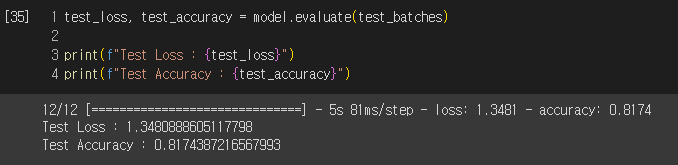

### 다섯번째 결과
- 데이터 증강 좌우 반전 + 상하 반전 + 밝기 0.2 + L2규제(0.01)

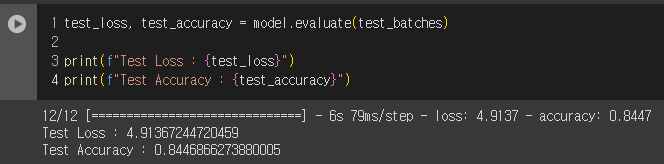

## 회고

레이어를 많이 수정도 해보고, 드롭아웃도 넣어보고, 규제도 넣어보고, 데이터 증강도 해봤습니다. seed값을 주지 않아 random하게 결과가 나와 85%이상을 도출 해내긴 했습니다만, VGG19모델은 VGG16보다 조금 나은 결과를 도출해주기는 하는 것 같습니다.
또한, 규제도 넣지 말아야 할 때를 알게 되었음. 더욱 정확성이 떨어지는 결과를 초래

- K
    - 다양한 데이터 증강을 수행 및 VGG19 모델 사용
- P
    - 정확도가 좋지 않게 나왔었으며, 시각화 문제 발생(검은색, 회색 이미지 도출)
    - 데이터 증강 후 정규화 부분에 문제가 생겨 정확도가 20%를 넘지 못함
- T
    - 데이터 증강 후 정규화 부분을 제거함으로써 높은 정확도와 시각화 이미지가 나옴